In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In questa esercitazione vedremo come utilizzare un oggetto di tipo [`Pipeline`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) per concatenare tra loro diversi stimatori. Partiamo, ovviamente, dalla generazione di un insieme di dati per il clustering; in tal senso, sfruttiamo il metodo [`make_blobs`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) messo a disposizione da Scikit Learn.

In [2]:
X, y = make_blobs(n_samples=1000, n_features=10, centers=5, random_state=42)

## Parte 1: generazione ed addestramento di una pipeline

Passiamo adesso a generare la nostra pipeline. Per farlo, usiamo un normale costruttore, cui passeremo una lista di tuple. Ciascuna delle tuple sarà nella forma:

```python
(name, classifier)
```

dove `name` è il nome del classificatore, mentre `classifier` è il classificatore stesso. Creiamo quindi una pipeline che articoli al suo interno i seguenti step:

1. scaling delle feature nel range $[0,1)$ con un transformer di tipo [`MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html);
2. estrazione delle prime tre componenti principali;
3. clustering con algoritmo KMeans.

In [3]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=3, random_state=42)),
    ('kmeans', KMeans(n_clusters=5, random_state=42))
])

Una volta creata la pipeline, questa può essere usata esattamente come un predittore, in quanto offre un'interfaccia a questo analoga. Proviamo quindi a fittare la pipeline ad `X`.

In [4]:
pipeline.fit(X)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('pca', PCA(n_components=3, random_state=42)),
                ('kmeans', KMeans(n_clusters=5, random_state=42))])

## Parte 2: accesso agli elementi della pipeline

E' interessante notare come sia possibile accedere ai singoli step che compongono la pipeline. Questo può essere fatto mediante indicizzazione, sia considerando l'indice numerico dello step, sia considerando il nome associato a ciascuno stimatore.

Ad esempio, per accedere al componente PCA, potremmo usare una tra le due seguenti notazioni:

```python
pipeline[1]
# oppure...
pipeline['pca']
```

> **Suggerimento**: la notazione più "comoda" è probabilmente quella che utilizza il nome dello stimatore.

Proviamo a visualizzare uno scatter plot che evidenzi i cluster associati ai diversi campioni.

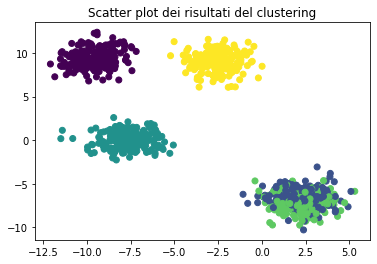

In [5]:
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], c=pipeline['kmeans'].labels_)
ax.set_title('Scatter plot dei risultati del clustering')
plt.show()

Analogamente, proviamo adesso a visualizzare la varianza descritta dalle tre componenti estratte dalla PCA.

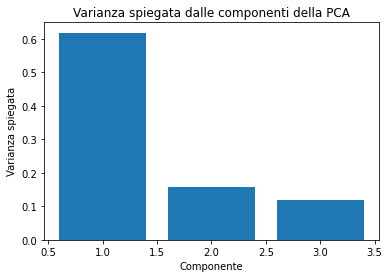

In [6]:
fig, ax = plt.subplots()
ax.bar([1,2,3], pipeline['pca'].explained_variance_ratio_)
ax.set_title('Varianza spiegata dalle componenti della PCA')
ax.set_xlabel('Componente')
ax.set_ylabel('Varianza spiegata')
plt.show()

## Parte 4: predizione con una pipeline

Abbiamo detto in precedenza che una pipeline offre un'interfaccia analoga a quella dei classici stimatori. Questo include, ovviamente, anche il classico metodo `predict`. Proviamo ad usarlo.

In [7]:
X_pr = np.random.rand(10)

print('Cluster predetto: {}'.format(pipeline.predict(X_pr.reshape(1, -1))))

Cluster predetto: [2]


Questo ci permette di evidenziare un altro vantaggio delle pipeline, ovvero che gli step di elaborazione sono *coerenti*. Usando i singoli step separatamente, infatti, ci si potrebbe "dimenticare" di normalizzare il dato in ingresso, o di sottoporlo a PCA, dando risultati di clustering spesso inconsistenti o errati.